In [90]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro, normaltest, anderson
import matplotlib.pyplot as plt
import seaborn as sns
import config
import os

# 데이터 로드
df = pd.read_csv(os.path.join(config.RESULT_ERROR_DIR, "predictions_by_feat_PriceUSD.csv"))

# 결과 저장 리스트
results = []

# train_size별 반복
for train_size in [30,45,60,75,90]:
    sub_df = df[df['train_size'] == train_size]
    if sub_df.empty:
        continue

    y = sub_df['actual']
    x = sub_df['forecast_ols']
    residuals = y - x
    X_const = sm.add_constant(x)

    # Durbin-Watson
    dw_stat = durbin_watson(residuals)

    # Breusch-Pagan test
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_const)

    # Shapiro-Wilk
    _, shapiro_p = shapiro(residuals)

    # D’Agostino K²
    _, dagostino_p = normaltest(residuals)

    # Jarque–Bera
    _, jb_pvalue, _, _ = jarque_bera(residuals)

    # Anderson–Darling
    anderson_result = anderson(residuals)
    anderson_stat = anderson_result.statistic
    # 5% 수준 기준값
    anderson_crit_5 = anderson_result.critical_values[2]
    anderson_reject = int(anderson_stat > anderson_crit_5)  # 1: 기각, 0: 수용

    # ADF
    _, adf_pvalue, *_ = adfuller(residuals)

    results.append({
        'Train_Size': train_size,
        'DurbinWatson': dw_stat,
        'BreuschPagan_p': bp_pvalue,
        'Shapiro_p': shapiro_p,
        'Dagostino_p': dagostino_p,
        'JarqueBera_p': jb_pvalue,
        'Anderson_stat': anderson_stat,
        'Anderson_crit@5%': anderson_crit_5,
        'Anderson_reject': anderson_reject,
        'ADF_p': adf_pvalue
    })

# 결과 저장 및 출력
results_df = pd.DataFrame(results)
print(results_df)

# 저장 (원할 경우 주석 해제)
# save_path = os.path.join(config.FIGURE_DIR, "ols_diagnostics_extended.csv")
# results_df.to_csv(save_path, index=False)



MissingDataError: exog contains inf or nans

   train_size  forecast_ols  forecast_rf  forecast_xgb  forecast_svr  \
0          30        0.0726       0.0446        0.0522        0.0458   
1          45        0.0715       0.0439        0.0506        0.0445   
2          60        0.0712       0.0437        0.0506        0.0447   
3          75        0.0699       0.0437        0.0505        0.0433   
4          90        0.0721       0.0434        0.0499        0.0437   

   forecast_mlp  
0        0.0726  
1        0.0715  
2        0.0712  
3        0.0699  
4        0.0721  


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2652322830.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df
C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2652322830.py:46: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2652322830.py:46: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2652322830.py:46: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\26523

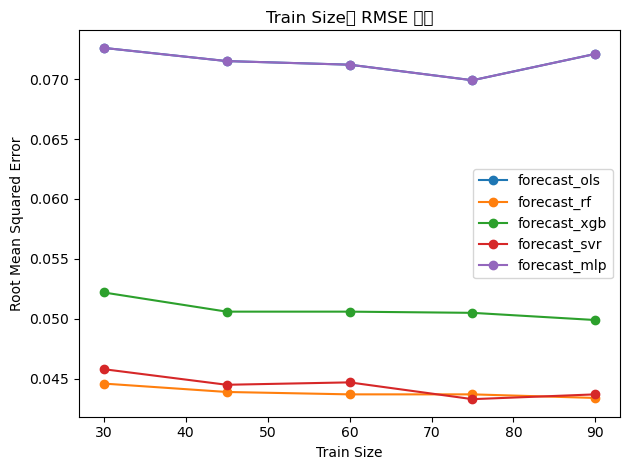

   train_size      rmse
0          30  0.045134
1          45  0.044082
2          60  0.044231
3          75  0.043871
4          90  0.043779


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2652322830.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('train_size')


In [157]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import config



csv_path = os.path.join(config.RESULT_ERROR_DIR, "predictions_by_feat_PriceUSD.csv")
df = pd.read_csv(csv_path).dropna()



def compute_rmse(actual: np.ndarray, forecast: np.ndarray) -> float:
    return np.sqrt(mean_squared_error(actual, forecast))

models = ['forecast_ols','forecast_rf', 'forecast_xgb','forecast_svr','forecast_mlp']

# 모델별 RMSE 계산
rmse_by_train_size_all = (
    df
    .groupby('train_size')
    .apply(lambda grp: pd.Series({
        m: round(compute_rmse(grp['actual'].values, grp[m].values), 4)
        for m in models
    }))
    .reset_index()
)

print(rmse_by_train_size_all)

# RMSE 그래프 그리기
plt.figure()
for model in models:
    plt.plot(
        rmse_by_train_size_all['train_size'],
        rmse_by_train_size_all[model],
        marker='o',
        label=model
    )
plt.xlabel('Train Size')
plt.ylabel('Root Mean Squared Error')
plt.title('Train Size별 RMSE 비교')
plt.legend()
plt.tight_layout()
plt.savefig("rmse_comparison_plot.png")  # 그래프도 저장
plt.show()

# 앙상블 예측 생성
forecast_columns = ['forecast_rf', 'forecast_xgb', 'forecast_svr']
df['forecast_ensemble'] = df[forecast_columns].mean(axis=1)

# 앙상블 RMSE 계산
rmse_ensemble = (
    df.groupby('train_size')
    .apply(lambda g: np.sqrt(mean_squared_error(g['actual'], g['forecast_ensemble'])))
    .reset_index(name='rmse')
)

print(rmse_ensemble)


csv_path = os.path.join(config.FIGURE_DIR, "rmse_by_model.csv")
rmse_by_train_size_all.to_csv(csv_path, index=False, float_format="%.3f")




In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import config

# --- 데이터 로드 ---
csv_path = os.path.join(config.RESULT_ERROR_DIR, "predictions_by_feat_PriceUSD.csv")
df = pd.read_csv(csv_path).dropna()

# --- 변동성 계산 및 regime 생성 ---
df['volatility'] = df['actual'].rolling(window=95).std()
df = df.dropna(subset=['volatility']).copy()

vol_thresh = df['volatility'].quantile(0.75)
df['regime'] = np.where(df['volatility'] >= vol_thresh, 'high_vol', 'low_vol')

# --- RMSE 함수 ---
def rmse(a, f):
    return round(np.sqrt(mean_squared_error(a, f)), 6)

# --- 모델 컬럼 매핑 ---
models = {
    'AR_RMSE':  'forecast_ols',
    'RF_RMSE':  'forecast_rf',
    'XGB_RMSE': 'forecast_xgb',
    'MLP_RMSE': 'forecast_mlp',
    'SVR_RMSE': 'forecast_svr',
}

# --- train_size & regime별 RMSE 계산 ---
grouped_rmse = (
    df.groupby(['train_size', 'regime'])
    .apply(lambda g: pd.Series({name: rmse(g['actual'], g[col]) for name, col in models.items()}))
    .reset_index()
)


# regime 별로 분리
high_vol_rmse = grouped_rmse[grouped_rmse['regime'] == 'high_vol'].reset_index(drop=True)
low_vol_rmse = grouped_rmse[grouped_rmse['regime'] == 'low_vol'].reset_index(drop=True)

# 출력 확인
print("\n=== High Volatility Regime RMSE ===")
print(high_vol_rmse)

print("\n=== Low Volatility Regime RMSE ===")
print(low_vol_rmse)

high_vol_path = os.path.join(config.FIGURE_DIR, "rmse_high_vol.csv")
low_vol_path = os.path.join(config.FIGURE_DIR, "rmse_low_vol.csv")

high_vol_rmse.to_csv(high_vol_path, index=False, float_format="%.3f")
low_vol_rmse.to_csv(low_vol_path, index=False, float_format="%.3f")




=== High Volatility Regime RMSE ===
   train_size    regime   AR_RMSE   RF_RMSE  XGB_RMSE  MLP_RMSE  SVR_RMSE
0          30  high_vol  0.079271  0.058828  0.067477  0.079271  0.060131
1          45  high_vol  0.084297  0.057370  0.064022  0.084297  0.058562
2          60  high_vol  0.080216  0.057487  0.066398  0.080216  0.058754
3          75  high_vol  0.077101  0.057624  0.067677  0.077101  0.055914
4          90  high_vol  0.080819  0.057708  0.065592  0.080819  0.057301

=== Low Volatility Regime RMSE ===
   train_size   regime   AR_RMSE   RF_RMSE  XGB_RMSE  MLP_RMSE  SVR_RMSE
0          30  low_vol  0.070494  0.039047  0.046457  0.070494  0.040277
1          45  low_vol  0.066800  0.038439  0.045292  0.066800  0.038845
2          60  low_vol  0.068015  0.038120  0.044193  0.068015  0.038931
3          75  low_vol  0.067321  0.037908  0.043341  0.067321  0.038262
4          90  low_vol  0.068873  0.037456  0.043361  0.068873  0.038086


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\449877836.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['train_size', 'regime'])


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\4016929598.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


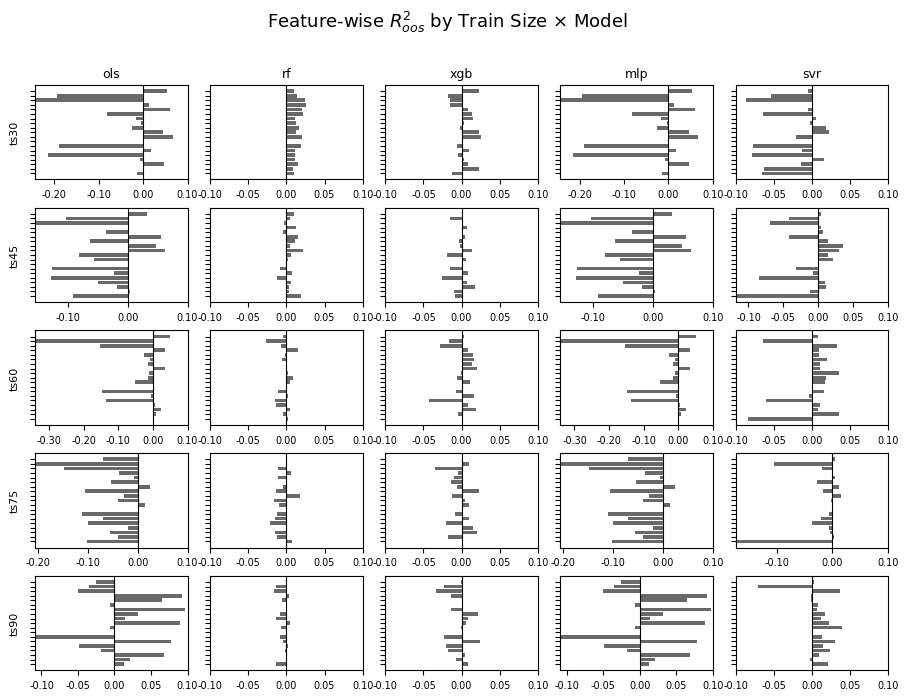

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import config

# 데이터 로딩
csv_path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(csv_path)

# 모델 및 train size 설정
models = ['ols', 'rf', 'xgb', 'mlp', 'svr']
train_sizes = [30, 45, 60, 75, 90]

# 피처 이름 고정
features = df['feature'].tolist()

# 시각화용 데이터 정리
plot_data = {}
for ts in train_sizes:
    plot_data[ts] = {}
    for model in models:
        col_name = f"RelR2_{model}_ts{ts}"
        plot_data[ts][model] = df[col_name].values

n_rows = len(train_sizes)
n_cols = len(models)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(2.2 * n_cols, 0.4 * len(features)),
    sharey=True,
    gridspec_kw={'wspace': 0.15, 'hspace': 0.3}
)

for i, ts in enumerate(train_sizes):
    for j, model in enumerate(models):
        ax = axes[i, j]
        values = plot_data[ts][model]

        ax.barh(features, values, color='dimgray')
        ax.axvline(0, color='black', linewidth=0.8)
        ax.set_xlim(min(values.min(), -0.1), max(values.max(), 0.1))  # 적절한 범위로 설정

        if i == 0:
            ax.set_title(model, fontsize=9)
        if j == 0:
            ax.set_ylabel(f"ts{ts}", fontsize=8)
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

plt.suptitle("Feature-wise $R^2_{oos}$ by Train Size × Model", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()




C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\19671801.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


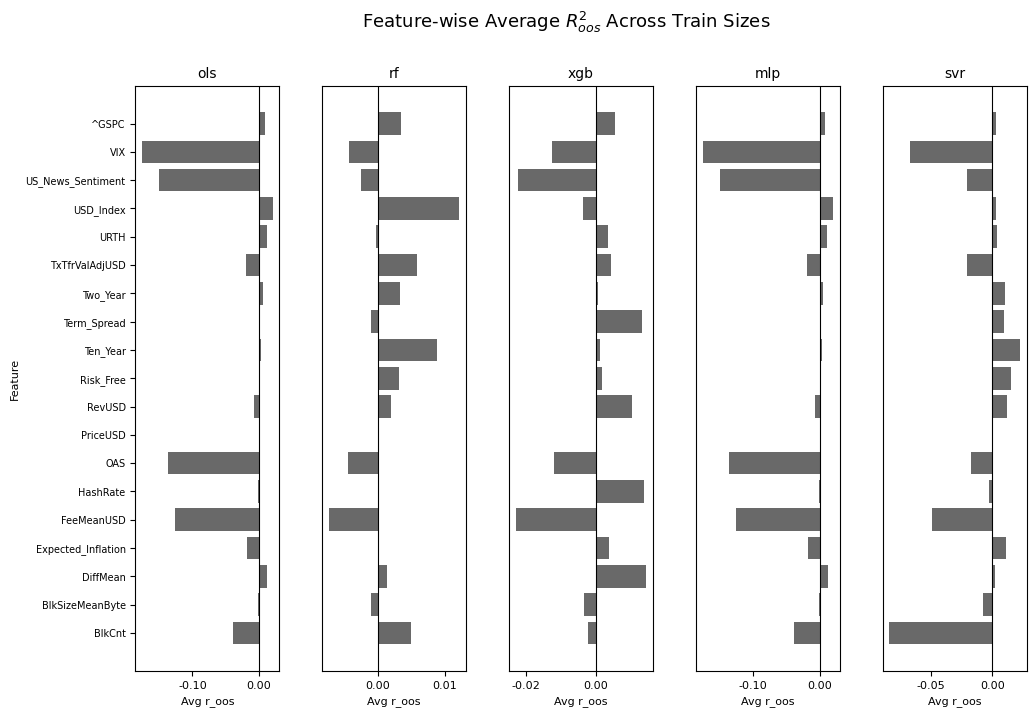

In [160]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import config

# 데이터 로딩
csv_path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(csv_path)

# 모델 및 train sizes
models = ['ols', 'rf', 'xgb', 'mlp', 'svr']
train_sizes = [30, 45, 60, 75, 90]
features = df['feature'].tolist()

# 평균 계산
plot_df = pd.DataFrame({'feature': features})
for model in models:
    cols = [f"RelR2_{model}_ts{ts}" for ts in train_sizes]
    plot_df[model] = df[cols].mean(axis=1)

plot_df.set_index('feature', inplace=True)

# 시각화
n_models = len(models)
fig, axes = plt.subplots(
    1, n_models,
    figsize=(2.3 * n_models, 0.4 * len(features)),
    sharey=False,  # ✅ y축 공유 해제
    gridspec_kw={'wspace': 0.3}
)

if n_models == 1:
    axes = [axes]

for i, model in enumerate(models):
    ax = axes[i]
    values = plot_df[model]

    ax.barh(plot_df.index, values, color='dimgray')
    ax.axvline(0, color='black', linewidth=0.8)

    ax.set_title(model, fontsize=10)
    ax.set_xlabel("Avg r_oos", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    if i == 0:
        ax.set_yticks(range(len(plot_df.index)))
        ax.set_yticklabels(plot_df.index.tolist(), fontsize=7)
        ax.set_ylabel("Feature", fontsize=8)
    else:
        ax.tick_params(axis='y', left=False, labelleft=False)


plt.suptitle("Feature-wise Average $R^2_{oos}$ Across Train Sizes", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\1778478308.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


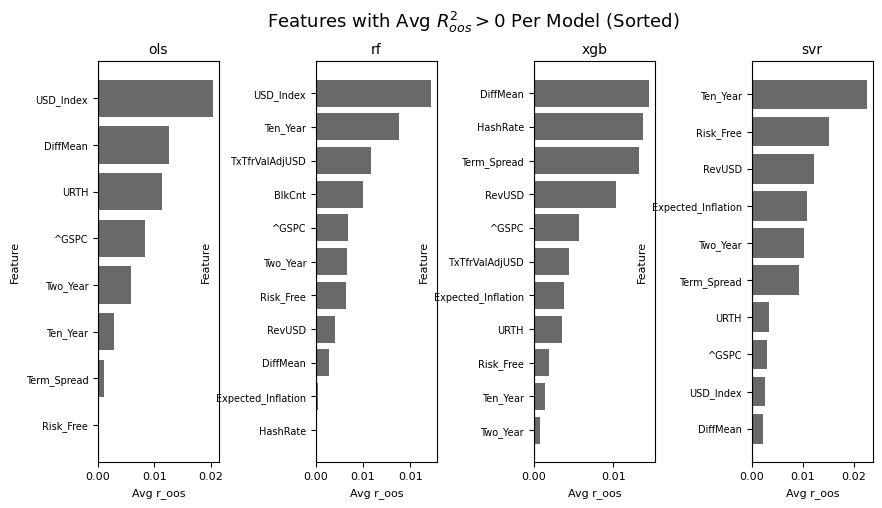

In [161]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import config

# 데이터 로딩
csv_path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(csv_path)

# 모델 및 train sizes
models = ['ols', 'rf', 'xgb', 'svr']
train_sizes = [30, 45, 60, 75, 90]

# 모델별 평균 R² 계산 & 조건 필터링
plot_df = pd.DataFrame({'feature': df['feature']})
for model in models:
    cols = [f"RelR2_{model}_ts{ts}" for ts in train_sizes]
    model_mean = df[cols].mean(axis=1)
    plot_df[model] = model_mean.where(model_mean > 0)

plot_df.set_index('feature', inplace=True)
plot_df.dropna(how='all', inplace=True)

# subplot 높이: feature 수에 따라 자동 조정
height_per_feature = 0.4
fig_height = max(3, height_per_feature * len(plot_df))
fig, axes = plt.subplots(
    1, len(models),
    figsize=(2.5 * len(models), fig_height),
    sharey=False,
    gridspec_kw={'wspace': 0.8}
)

if len(models) == 1:
    axes = [axes]

# 모델별 subplot
for i, model in enumerate(models):
    ax = axes[i]
    values = plot_df[model].dropna().sort_values(ascending=True)

    ax.barh(values.index, values, color='dimgray')
    ax.axvline(0, color='black', linewidth=0.8)

    ax.set_title(model, fontsize=10)
    ax.set_xlabel("Avg r_oos", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    ax.set_yticks(range(len(values.index)))
    ax.set_yticklabels(values.index.tolist(), fontsize=7)
    ax.set_ylabel("Feature", fontsize=8)

plt.suptitle("Features with Avg $R^2_{oos} > 0$ Per Model (Sorted)", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\3930765005.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


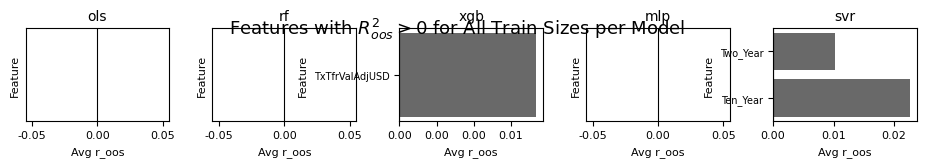

In [148]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import config

# 데이터 로딩
csv_path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(csv_path)

# 모델 및 train sizes
models = ['ols', 'rf', 'xgb', 'mlp', 'svr']
train_sizes = [30, 45, 60, 75, 90]

# 모델별로 train size 전부에서 R² > 0 인 feature만 추출
plot_df = pd.DataFrame({'feature': df['feature']})
for model in models:
    cols = [f"RelR2_{model}_ts{ts}" for ts in train_sizes]
    
    # 조건: 모든 train size에서 R² > 0
    mask = (df[cols] > 0).all(axis=1)
    
    # 조건 만족하는 feature의 평균 R² 저장
    plot_df[model] = df.loc[mask, cols].mean(axis=1)

plot_df.set_index('feature', inplace=True)
plot_df.dropna(how='all', inplace=True)

# 시각화
n_models = len(models)
fig, axes = plt.subplots(
    1, n_models,
    figsize=(2.3 * n_models, 0.4 * len(plot_df)),
    sharey=False,
    gridspec_kw={'wspace': 0.3}
)

if n_models == 1:
    axes = [axes]

for i, model in enumerate(models):
    ax = axes[i]
    values = plot_df[model].dropna()

    ax.barh(values.index, values, color='dimgray')
    ax.axvline(0, color='black', linewidth=0.8)

    ax.set_title(model, fontsize=10)
    ax.set_xlabel("Avg r_oos", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    ax.set_yticks(range(len(values.index)))
    ax.set_yticklabels(values.index.tolist(), fontsize=7)
    ax.set_ylabel("Feature", fontsize=8)

plt.suptitle("Features with $R^2_{oos} > 0$ for All Train Sizes per Model", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [149]:
import pandas as pd
import os
import config

# 파일 경로
csv_path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")

# 데이터 로드
df = pd.read_csv(csv_path)

# 대상 모델과 상위 feature 개수 설정
models = ['ols','mlp', 'svr', 'rf', 'xgb']
top_k = 5

# 모델별 top-k feature 저장용 딕셔너리
model_top_features = {}

for model in models:
    # 해당 모델 관련 열만 선택
    model_cols = [col for col in df.columns if f'RelR2_{model}_ts' in col]
    
    # 평균 rel_r2 계산
    mean_col = f'{model}_mean'
    df[mean_col] = df[model_cols].mean(axis=1)
    
    # 평균 기준 상위 feature 추출
    top_features = df[['feature', mean_col]].sort_values(by=mean_col, ascending=False).head(top_k)
    model_top_features[model] = top_features.reset_index(drop=True)

# 결과 출력 (선택적으로 DataFrame으로 합쳐서 표시 가능)
for model, top_df in model_top_features.items():
    print(f"\nTop {top_k} features for model: {model.upper()}")
    print(top_df)



Top 5 features for model: OLS
    feature  ols_mean
0      URTH   0.02046
1     ^GSPC   0.01492
2  Two_Year   0.01414
3  Ten_Year   0.01330
4  DiffMean   0.00776

Top 5 features for model: MLP
    feature  mlp_mean
0      URTH   0.02046
1     ^GSPC   0.01492
2  Two_Year   0.01414
3  Ten_Year   0.01330
4  DiffMean   0.00776

Top 5 features for model: SVR
              feature  svr_mean
0            Ten_Year   0.02262
1           Risk_Free   0.01522
2              RevUSD   0.01212
3  Expected_Inflation   0.01092
4            Two_Year   0.01026

Top 5 features for model: RF
          feature  rf_mean
0       USD_Index  0.00598
1       Risk_Free  0.00504
2          BlkCnt  0.00462
3        Ten_Year  0.00388
4  TxTfrValAdjUSD  0.00346

Top 5 features for model: XGB
          feature  xgb_mean
0        DiffMean   0.00874
1        HashRate   0.00824
2  TxTfrValAdjUSD   0.00736
3     Term_Spread   0.00564
4          RevUSD   0.00552


In [150]:
import os
import numpy as np
import pandas as pd
import config

csv_path = os.path.join(config.RESULT_ERROR_DIR, "predictions_by_feat_PriceUSD.csv")
df = pd.read_csv(csv_path)

models = ['forecast_ols', 'forecast_rf', 'forecast_xgb', 'forecast_svr', 'forecast_mlp']

rel_var_by_train_size = (
    df
    .groupby('train_size')
    .apply(lambda grp: pd.Series({
        model: np.var(grp[model].values) / np.var(grp['actual'].values)
        for model in models
    }))
    .reset_index()
)

print(rel_var_by_train_size)

   train_size  forecast_ols  forecast_rf  forecast_xgb  forecast_svr  \
0          30      2.154497     0.176595      0.563719      0.261116   
1          45      2.159960     0.170259      0.493387      0.198256   
2          60      2.048141     0.133648      0.461441      0.193691   
3          75      2.297518     0.136264      0.455436      0.150254   
4          90      2.092728     0.152739      0.433087      0.152412   

   forecast_mlp  
0      2.154497  
1      2.159960  
2      2.048141  
3      2.297518  
4      2.092728  


C:\Users\Hoseung\AppData\Local\Temp\ipykernel_13976\2862668989.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [36]:
import pandas as pd
import os
import config

# 1. 파일 경로 지정 (RMSE 기준 파일)
path = os.path.join(config.RESULT_DIR, "rmse_by_feature.csv")
df = pd.read_csv(path)

# 2. 모델명과 train size tag
models = ['ols', 'rf', 'xgb', 'mlp', 'svr']
ts = 'ts90'  # 예: train_size 90

# 3. 사용할 컬럼 구성
cols = [f"RMSE_{model}_{ts}" for model in models]
selected_df = df[['feature'] + cols].copy()

# 4. 컬럼 이름 정리
selected_df.columns = ['feature'] + models
selected_df.set_index('feature', inplace=True)

# 5. 출력
print(f"\n=== {ts} 기준 모델별 RMSE 비교 테이블 ===")
print(selected_df.to_string())

# 6. 저장
selected_df.to_csv('rmse_linear_vs_non_linear.csv')
display(selected_df)



=== ts90 기준 모델별 RMSE 비교 테이블 ===
                       ols      rf     xgb     mlp     svr
feature                                                   
BlkCnt              0.0729  0.0437  0.0473  0.0729  0.0442
BlkSizeMeanByte     0.0667  0.0434  0.0477  0.0667  0.0442
DiffMean            0.0659  0.0434  0.0468  0.0659  0.0446
Expected_Inflation  0.0650  0.0436  0.0474  0.0650  0.0441
FeeMeanUSD          0.0730  0.0435  0.0477  0.0730  0.0439
HashRate            0.0650  0.0434  0.0473  0.0650  0.0447
OAS                 0.0715  0.0437  0.0476  0.0715  0.0438
PriceUSD            0.0655  0.0435  0.0473  0.0655  0.0445
RevUSD              0.0661  0.0433  0.0469  0.0661  0.0442
Risk_Free           0.0639  0.0434  0.0473  0.0639  0.0443
Ten_Year            0.0643  0.0435  0.0472  0.0643  0.0447
Term_Spread         0.0646  0.0434  0.0469  0.0646  0.0446
Two_Year            0.0640  0.0433  0.0477  0.0640  0.0445
TxTfrValAdjUSD      0.0678  0.0436  0.0473  0.0678  0.0442
URTH                0.0

,ols,rf,xgb,mlp,svr
feature,,,,,
BlkCnt,0.0729,0.0437,0.0473,0.0729,0.0442
BlkSizeMeanByte,0.0667,0.0434,0.0477,0.0667,0.0442
DiffMean,0.0659,0.0434,0.0468,0.0659,0.0446
Expected_Inflation,0.0650,0.0436,0.0474,0.0650,0.0441
FeeMeanUSD,0.0730,0.0435,0.0477,0.0730,0.0439
HashRate,0.0650,0.0434,0.0473,0.0650,0.0447
OAS,0.0715,0.0437,0.0476,0.0715,0.0438
PriceUSD,0.0655,0.0435,0.0473,0.0655,0.0445
RevUSD,0.0661,0.0433,0.0469,0.0661,0.0442


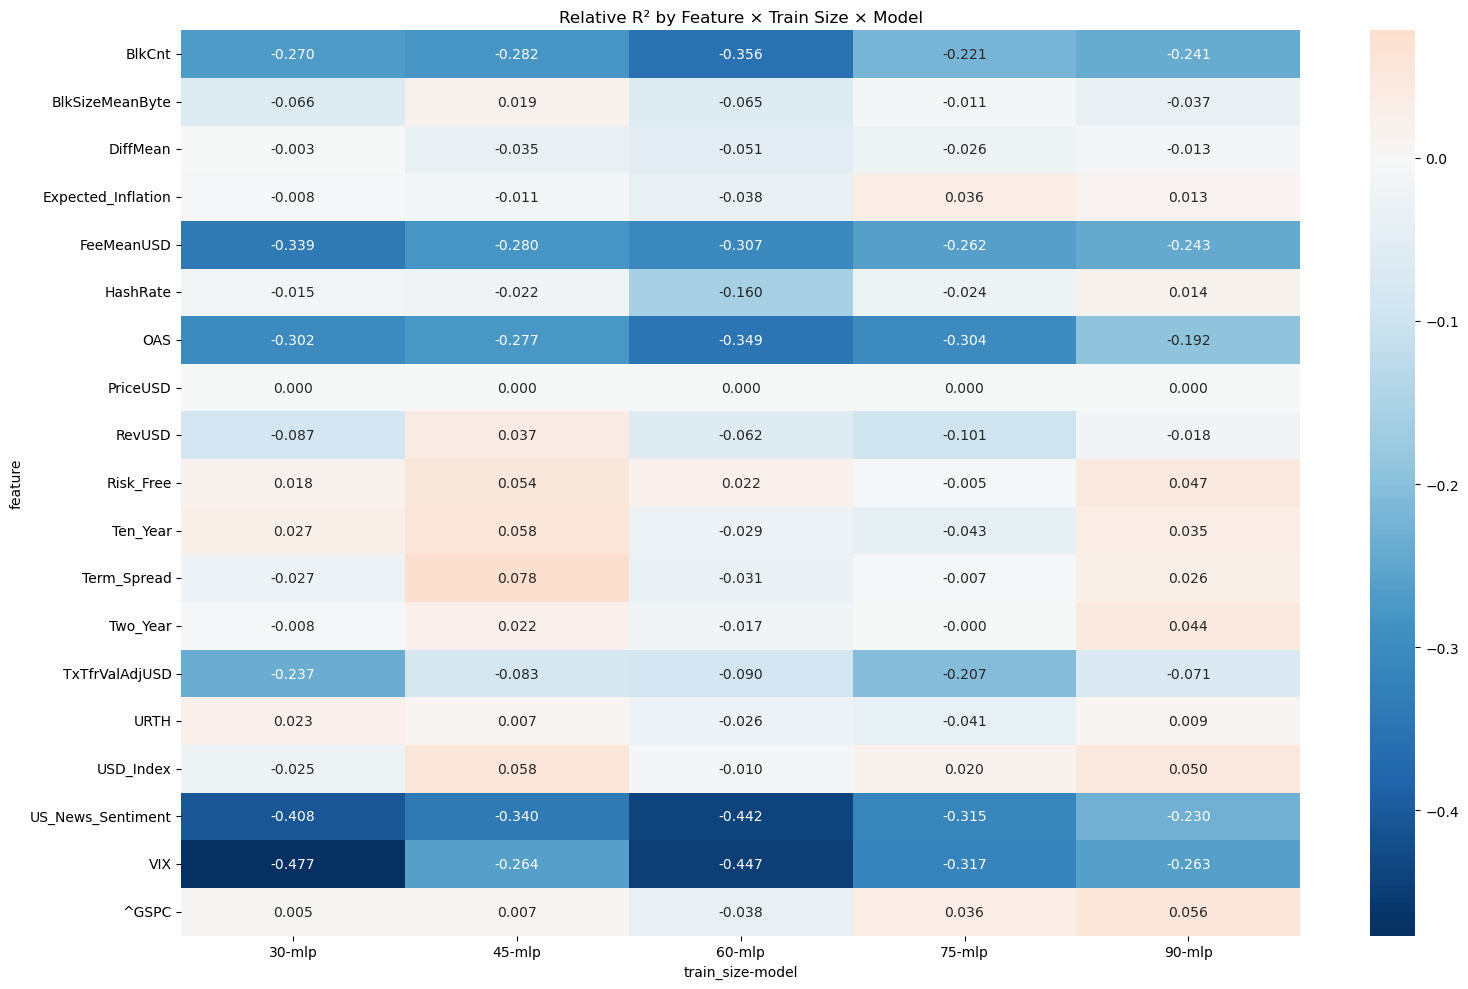

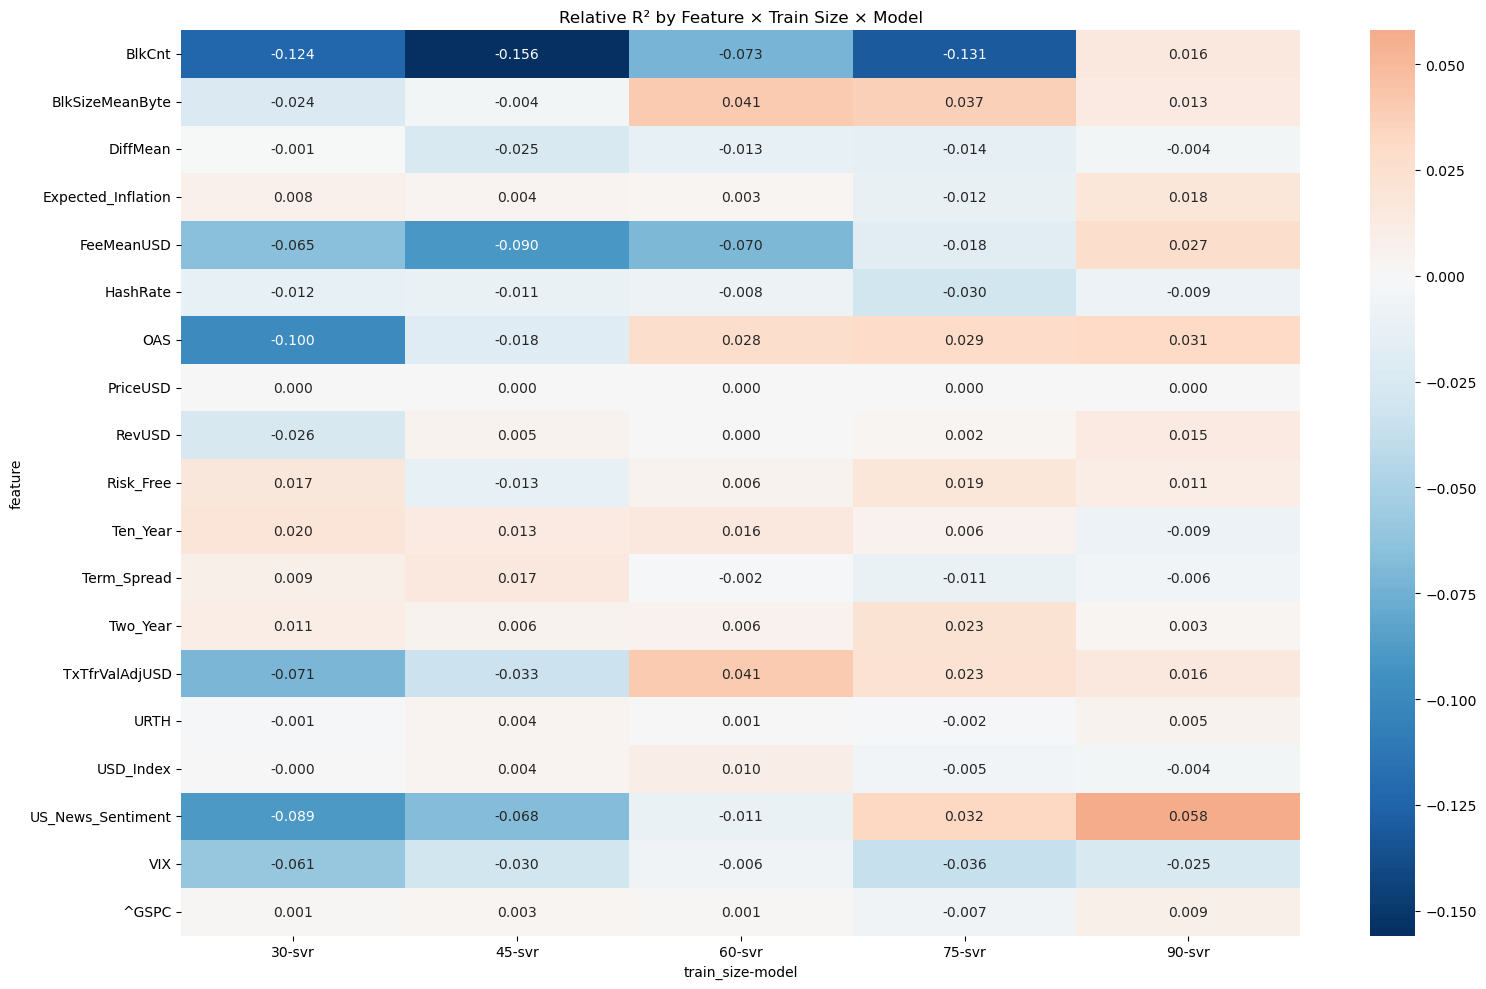

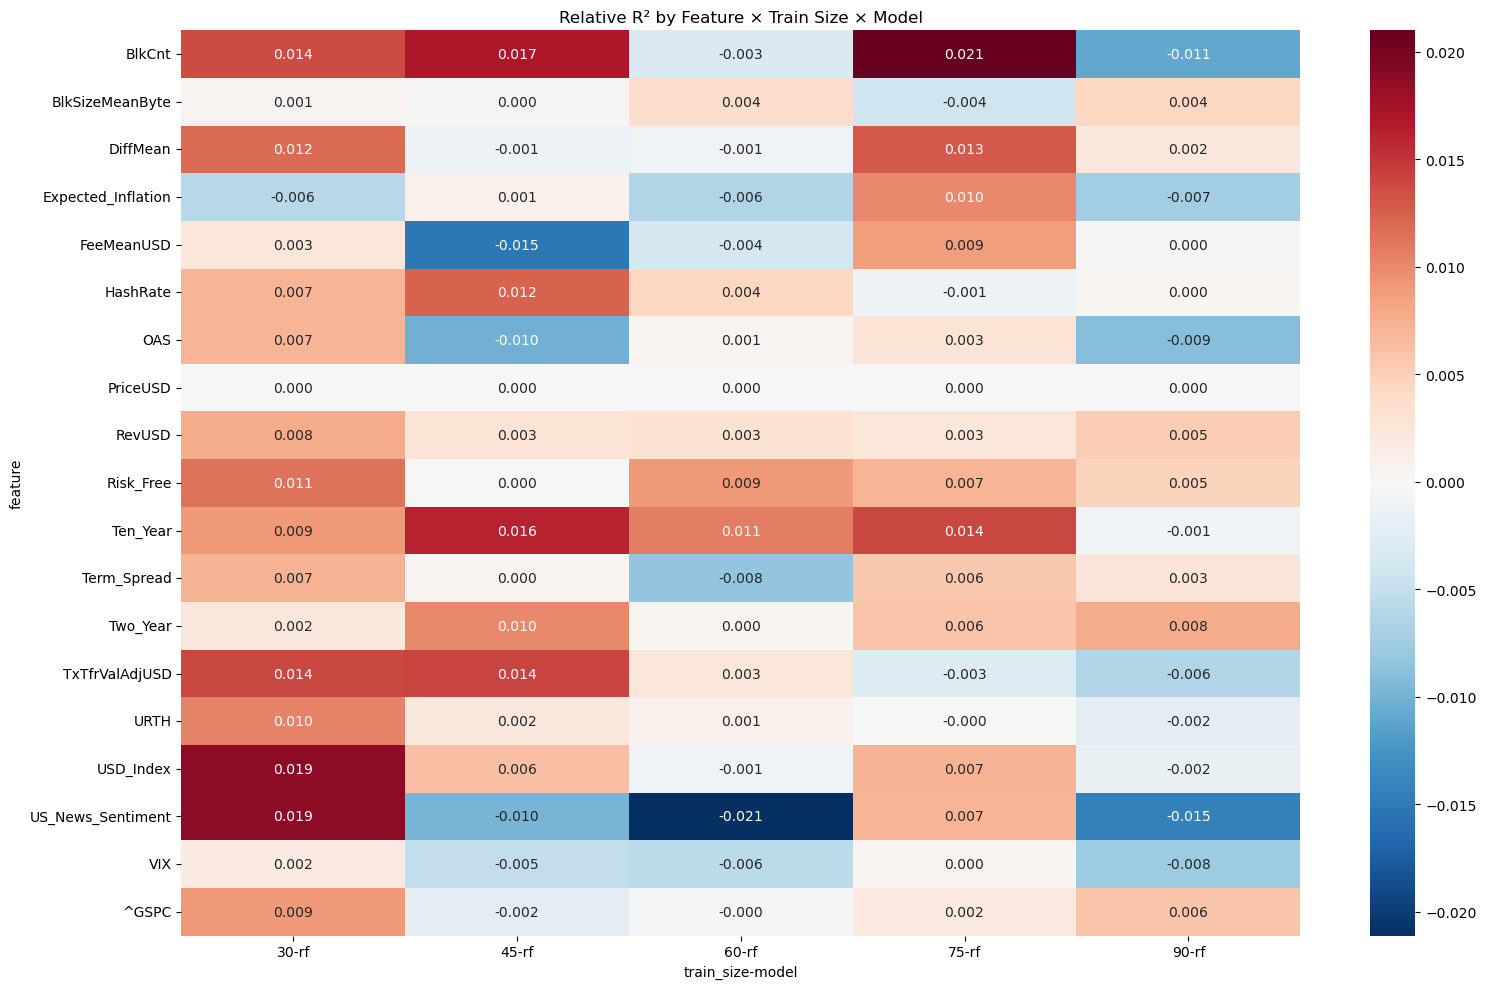

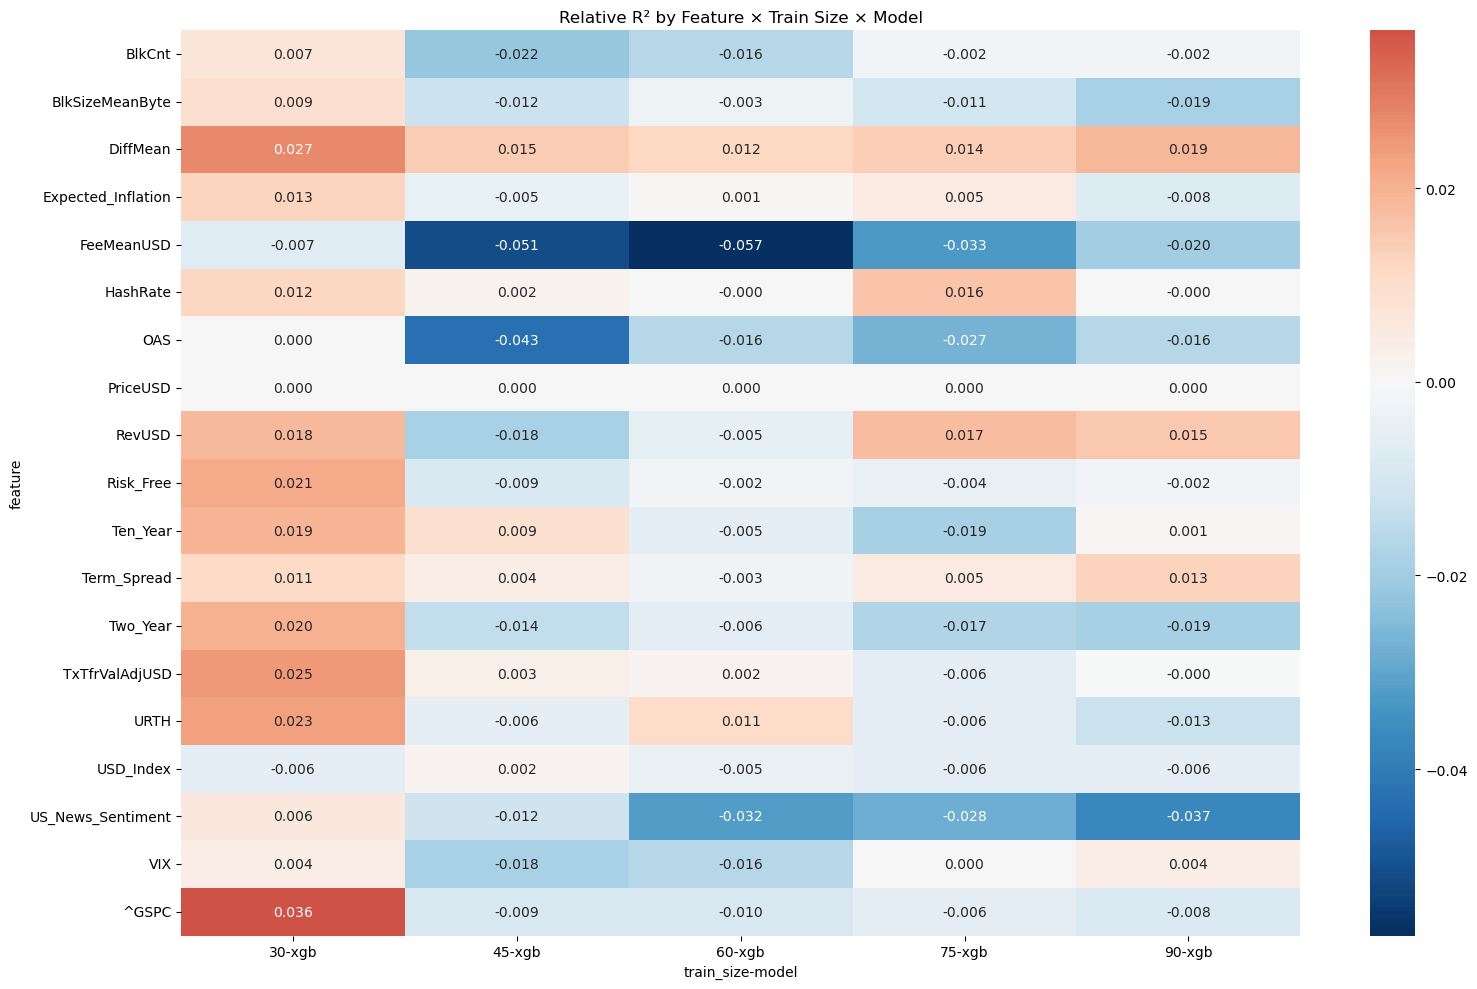

In [17]:
import pandas as pd
import os
import config

path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(path)


# Long-format으로 변환
df_melted = df.melt(id_vars="feature", var_name="model_train", value_name="rel_r2")

# 모델명과 train size 추출
df_melted[['model', 'train_size']] = df_melted['model_train'].str.extract(r'RelR2_(\w+)_ts(\d+)')
df_melted['train_size'] = df_melted['train_size'].astype(int)

selected_models = ['mlp', 'svr', 'rf', 'xgb']
top_k = 3  # 상위 몇 개 feature 볼지

for model in selected_models:
    df_model = df_melted[df_melted['model'] == model]
    
    
    # Heatmap용 Pivot 테이블 생성 (행: feature, 열: (train_size, model))
    heatmap_data = df_model.pivot_table(index="feature", columns=["train_size", "model"], values="rel_r2")
    
    # 예시 출력: heatmap 그리기 (seaborn)
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(heatmap_data.sort_index(), cmap="RdBu_r", center=0, annot=True, fmt=".3f")
    plt.title("Relative R² by Feature × Train Size × Model")
    plt.tight_layout()
    plt.show()

In [162]:
import pandas as pd

path = os.path.join(config.RESULT_DIR, "relative_r2_by_feature.csv")
df = pd.read_csv(path)
df = df.loc[:, ~df.columns.str.contains(r'_mlp_')]

df = df[df['feature'] != 'PriceUSD']

# feature 열을 인덱스로 설정
df.set_index('feature', inplace=True)

# 통계량 계산
summary = (
    pd.DataFrame({
        "Mean R²": df.mean(axis=1).round(3),
        "Median R²": df.median(axis=1),
        "Std Dev": df.std(axis=1),
        "Min": df.min(axis=1),
        "Max": df.max(axis=1),
        "Positive Share": (df > 0).sum(axis=1) / df.shape[1]
    })
    .round(4)
)

summary = summary.sort_values('Positive Share', ascending=False)

# 저장 (선택 사항)
summary.to_csv('feature_importance_summary.csv')
display(summary)

PermissionError: [Errno 13] Permission denied: 'feature_importance_summary.csv'

In [21]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv(csv_path)

# Sharpe Ratio 계산 함수
def compute_sharpe(returns, risk_free):
    excess_returns = returns - risk_free
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1)

# Sharpe Ratio를 train_size 별로 구함
def rolling_sharpe(df, train_size=5):
    results = []
    for i in range(len(df) - train_size + 1):
        window = df.iloc[i:i + train_size]
        sharpe = compute_sharpe(window["Mean R"], window["Risk_Free"])
        results.append((i, sharpe))
    return results


